<a href="https://colab.research.google.com/github/kuramapw/rfslf/blob/master/QPSK_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#инициализация необходимых библиотек
import random     
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
%matplotlib inline

In [0]:
fd=10**9  #частота дискретизации
fn=10**8  #частота несущей
els=5
length=int(fd*els/fn)

In [0]:
#здесь мы вбиваем текст, преобразуем его в двоичный код
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

In [0]:
#здесь мы из двоичного кода получаем текст
def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

In [0]:
#функция модуляции QPSK
def QPSK(d1,d2,t,fn):                                       
    return  (2.**(-0.5))*(d1*np.cos(2.*np.pi*fn*t) + d2*np.sin(2.*np.pi*fn*t))

In [0]:
#здесь мы преобразуем текст в колебание с манипуляцией QPSK
def manipulator(information, fd, fn, els, graph=0):
    inform_binary=information
    sig=np.array(list(inform_binary),int)
    print(sig)
    sigtemp=np.array([],int)
    n=int(np.shape(sig)[0])
    #print(n)
    length=int(els*fd/fn)
    for i in sig:
        if(i==0):
            sigtemp=np.append(sigtemp,-1)
        if(i==1):
            sigtemp=np.append(sigtemp,1)
    #print(sigtemp)
    signaltemp=[]                                                 #делаем вспомогательный массив из пар битов [-1,1]
    i=0
    while i<n:
        signaltemp.append([sigtemp[i],sigtemp[i+1]])
        i=i+2
    #print(signaltemp)
    s=np.array([],float)
    global time
    time=np.arange(0,int(length*n/2)/fd,1/fd)
    i=0
    while i<(n/2):
        t=time[i*length:length*(i+1)]
        temp1=QPSK( signaltemp[i][0] , signaltemp[i][1] , t , fn )
        s=np.append(s,temp1)
        i=i+1 
    if(graph==1):
        plt.figure(num=None, figsize=(19, 4), dpi=80) 
        plt.plot(list(time),list(s))      
        plt.show()
    return s


[0 1 0 0 0 0 0 1]


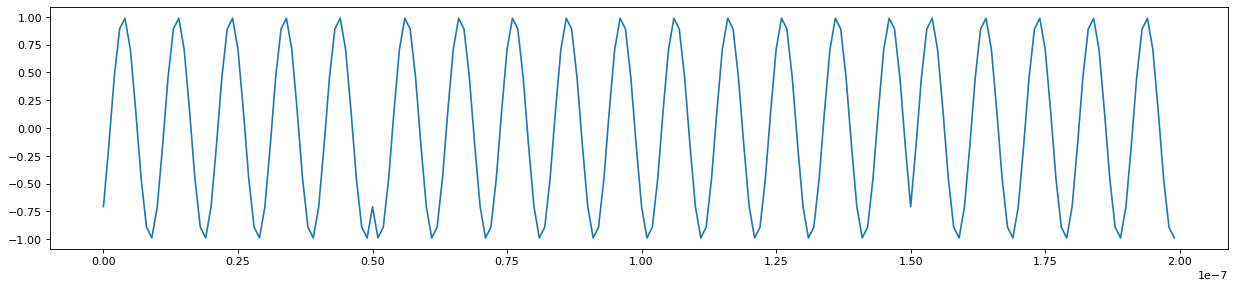

[-0.70710678 -0.15643447  0.4539905   0.89100652  0.98768834  0.70710678
  0.15643447 -0.4539905  -0.89100652 -0.98768834 -0.70710678 -0.15643447
  0.4539905   0.89100652  0.98768834  0.70710678  0.15643447 -0.4539905
 -0.89100652 -0.98768834 -0.70710678 -0.15643447  0.4539905   0.89100652
  0.98768834  0.70710678  0.15643447 -0.4539905  -0.89100652 -0.98768834
 -0.70710678 -0.15643447  0.4539905   0.89100652  0.98768834  0.70710678
  0.15643447 -0.4539905  -0.89100652 -0.98768834 -0.70710678 -0.15643447
  0.4539905   0.89100652  0.98768834  0.70710678  0.15643447 -0.4539905
 -0.89100652 -0.98768834 -0.70710678 -0.98768834 -0.89100652 -0.4539905
  0.15643447  0.70710678  0.98768834  0.89100652  0.4539905  -0.15643447
 -0.70710678 -0.98768834 -0.89100652 -0.4539905   0.15643447  0.70710678
  0.98768834  0.89100652  0.4539905  -0.15643447 -0.70710678 -0.98768834
 -0.89100652 -0.4539905   0.15643447  0.70710678  0.98768834  0.89100652
  0.4539905  -0.15643447 -0.70710678 -0.98768834 -0.89

In [0]:
s=manipulator(text_to_bits("A"), fd, fn, els, 1)
print(s)

50


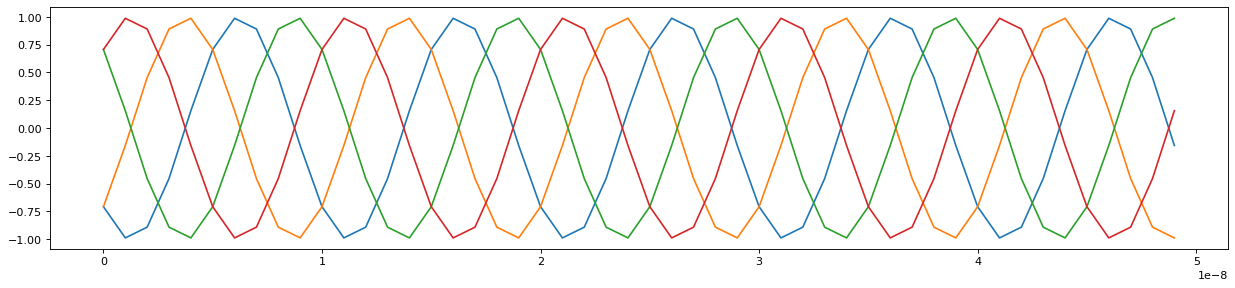

In [0]:
#формируем эталонные массивы
s00=np.array([])    
s01=np.array([])
s10=np.array([])
s11=np.array([])
t=np.array([])
for i in range(length):
    t=np.append(t,i/fd)
print(len(t))
s00=np.append(s00,QPSK(-1,-1,t,fn))
s01=np.append(s01,QPSK(-1,1,t,fn))
s10=np.append(s10,QPSK(1,-1,t,fn))
s11=np.append(s11,QPSK(1,1,t,fn))
plt.figure(num=None, figsize=(19, 4), dpi=80) 
plt.plot(t, s00)
plt.plot(t, s01)
plt.plot(t, s10)
plt.plot(t, s11)     
plt.show()

In [0]:
#корреляционный детектор
def kor_priem(intern_signal):      
    kf0=kf1=kf2=kf3=0
    dt=t[1]-t[0]

    for i in range(len(t)):
        kf0+=intern_signal[i]*s00[i]*dt
        kf1+=intern_signal[i]*s01[i]*dt
        kf2+=intern_signal[i]*s10[i]*dt
        kf3+=intern_signal[i]*s11[i]*dt
    mx=max(kf0,kf1,kf2,kf3)
    if(mx==kf0):
        return [0,0]
    if(mx==kf1):
        return [0,1]
    if(mx==kf2):
        return [1,0]
    if(mx==kf3):
        return [1,1]

In [0]:
#Здесь мы принимаем колебание и достаем оттуда информацию
def priemnik(input_signal,fd,fn,els, graph=0):
    
    #можно еще вспомнить последний вопрос с экза по статам про оптимальное обнаружение
    x_intern=input_signal
    s_intern=np.array([],int)
    for i in range(int(len(input_signal)/(length))):
        s_intern=np.append(s_intern, kor_priem(x_intern[i*length:length*(i+1)]))
    if(graph==1):
        plt.figure(num=None, figsize=(19, 4), dpi=80) 
        plt.plot(time, x_intern)
        plt.show()
    return s_intern

[0 1 0 0 0 0 0 1]


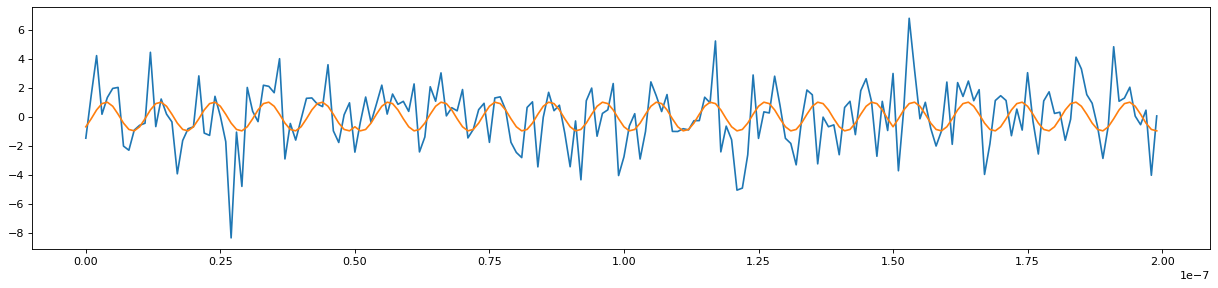

In [0]:
d=2
noise=[np.random.normal(0,d) for i in s]
wave=s+noise
plt.figure(num=None, figsize=(19,4), dpi=80)
plt.plot(time, wave)
plt.plot(time, manipulator(priemnik(wave,fd,fn,els),fd,fn,els))
#plt.plot(time, noise)
plt.show()
#зависимость ошибки от snr
#посчитать энергию сигнала которго передал, спектральную плотность мощности шума(сигма2???)
#ОСШ от 0 до 8дБ с шагом 1 дБ
#по сути нужно найти сигму2 которая соответствует этому ОСШ
#построить теоретический график из метоички для QpSK(найти формулу для вер ошибки qpsk)
#и сравнить графики